In [1]:
%matplotlib inline
import os

import numpy as np
import xarray as xr

import util

In [2]:
ds_prosp = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf-prospective-trends.zarr')
ds_prosp

<xarray.Dataset>
Dimensions:       (length: 3, member_id: 34, nlat: 93, nlon: 320, trend_length: 4, trend_year: 2)
Coordinates:
    KMT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * length        (length) float64 20.0 40.0 60.0
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * trend_length  (trend_length) int64 5 10 20 50
  * trend_year    (trend_year) int64 2006 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    IFRAC         (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    KGP           (trend_length, trend_year, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 3, 1, 93, 320), meta=np.ndarray>
    SST           (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    SST_orig      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>

### Adjust DS to make selecting array's tidy

In [4]:
ds_trends = ds_prosp.sel(length='40').where(ds_prosp.KMT > 0)
ds_trends

<xarray.Dataset>
Dimensions:       (member_id: 34, nlat: 93, nlon: 320, trend_length: 4, trend_year: 2)
Coordinates:
    KMT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length        float64 40.0
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * trend_length  (trend_length) int64 5 10 20 50
  * trend_year    (trend_year) int64 2006 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    IFRAC         (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    KGP           (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    SST           (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>
    SST_orig      (trend_length, trend_year, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 1, 93, 320), meta=np.ndarray>

# Import plotting mods and make plotting structures

In [3]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar # For dealing with Colorbars the proper way - TBD in a separate PyCoffee ?
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

#### Set up dataset to plot

### Set up for polar plots:

In [8]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#alt levels: 
levels = np.linspace(-0.03, 0.07, 11)
levels_cont = [0]

cmap = cmocean.cm.curl_r

norm = MidpointNormalize(midpoint=0.)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]
prj = ccrs.SouthPolarStereo()

In [36]:
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels,
                     norm=norm,
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k',
                    levels=levels_cont,
                    linewidths=0.25,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

### Plot

In [ ]:
kgptrend_20_20 = ds_prosp['KGP'].sel(trend_length = 20, trend_year = 2020, length = 40. )
kgptrend_20_50 = ds_prosp['KGP'].sel(trend_length = 50, trend_year = 2020, length = 40. )


In [37]:
# Polar Plottable
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'kgp': ds_trends['KGP'],
        'sst': ds_trends['SST'],
        'chl': ds_trends['Chl_surf'],
        'TLAT': ds_trends.TLAT.compute(),
        'TLONG': ds_trends.TLONG.compute() } )) 
dsp

,Array,Chunk
Bytes,64.96 MB,119.78 kB
Shape,"(4, 2, 34, 93, 321)","(1, 1, 1, 93, 161)"
Count,2996 Tasks,816 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,64.96 MB,119.78 kB
Shape,"(4, 2, 34, 93, 321)","(1, 1, 1, 93, 161)"
Count,2724 Tasks,816 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


#### input: variable, trend length, trend year
#### output: single map of the mean of specified values

In [38]:
v = 'kgp'
tl = 20
ty = 2020



In [39]:
v = 'kgp'
tl = 20
ty = 2020
tend = ty + tl

forced = dsp[v].sel(trend_length = [tl], trend_year = [ty]).mean('member_id').compute()
forced

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'kgp' (trend_length: 1, trend_year: 1, nlat: 93, nlon: 321)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
    length        float64 40.0
  * trend_length  (trend_length) int64 20
  * trend_year    (trend_year) int64 2020
Dimensions without coordinates: nlat, nlon

TypeError: Input z must be 2D, not 4D

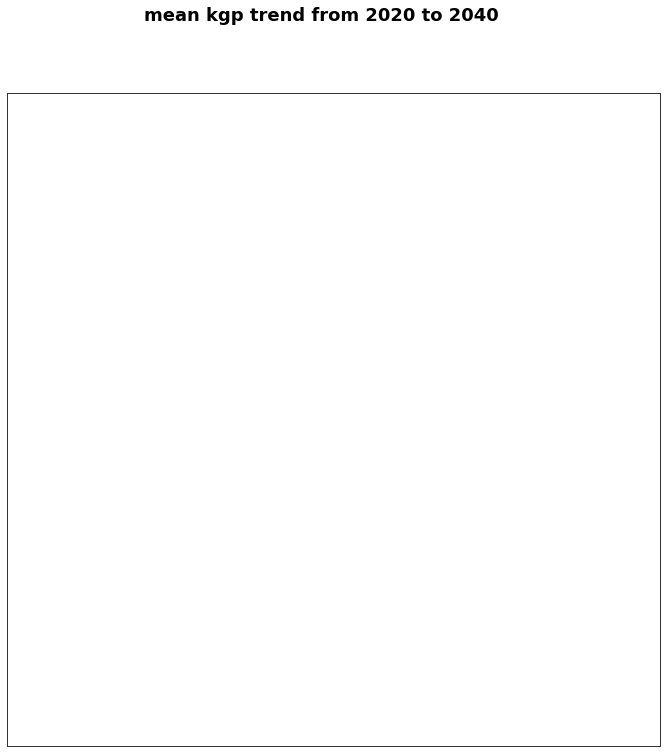

In [41]:
fig = plt.figure(figsize=(14, 12))
axs = []
plt.suptitle(f'mean {v} trend from {ty} to {tend}', fontsize = 18, fontweight = 'bold')

ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
one_plot(forced)
ax.set_title('Forced', pad=15, fontsize = 25, fontweight='bold')
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.9, orientation='horizontal', ax=axs, pad=0.075)
cb.set_label('mm day$^{-1}$ (decade)$^{-1}$', labelpad=10, fontsize = 18)
cb.ax.tick_params(labelsize=16)


TypeError: Input z must be 2D, not 4D

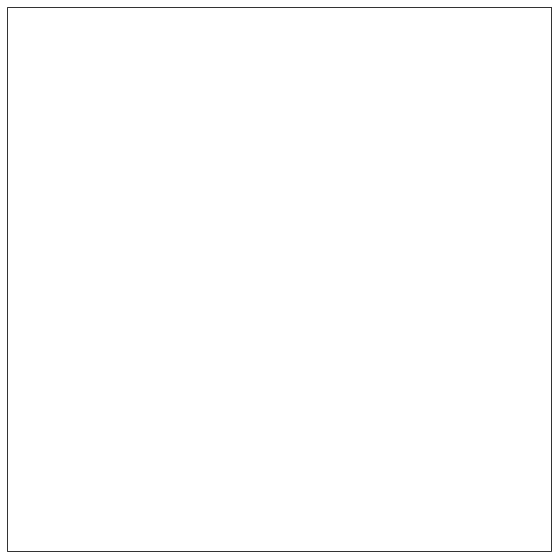

In [34]:
fig = plt.figure(figsize=(12, 10))
axs = []
# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

cf = plot_standard(forced)

ax.set_title(f'mean {v} trend from {ty} to {tend}', fontsize = 18, fontweight = 'bold',pad=10)
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.65, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.set_title('Change in Growth Potential (mm day$^{-1}$)', pad=5, fontsize = 14)
cb.ax.tick_params(labelsize=12)

title = ('epoch-diff-KGP')
path = 'figures/'
file = '.pdf'
#plt.savefig(path + title + file, bbox_inches='tight')